In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

import os

In [2]:
def getTotalTime(exp):
    ops = 2 * exp['alg_info']['nnz'] * 2 * exp['alg_info']['r'] * exp['num_trials']
    return ops / (exp['overall_throughput'] * 1e9)

def get_best_cval_exps(exps, alg_name, fused):    
    filtered = [exp for exp in exps if exp['alg_name']==alg_name and exp['fused'] == fused]
    pValues = [exp['alg_info']['p'] for exp in filtered]
    pValues = sorted(list(dict.fromkeys(pValues)))
    
    res = []
    
    for p in pValues:
        sexps = sorted([exp for exp in filtered if exp['alg_info']['p'] == p], key=getTotalTime)
        res.append(sexps[0])

    return res

def getExps(filename):
    f = open('distributed_sddmm/{}'.format(filename), 'r')
    return json.load(f)

def getExps_progress(filename):
    f = open('distributed_sddmm/{}'.format(filename), 'r')
    lines = '\n'.join(f.readlines())
    lines = "[" + lines[:-1].rstrip(',') + "]"
    return json.loads(lines)

def generateScalingPlot(results, alg_name, fused, label, cm, ax, fil=0):
    color, marker = cm
    best_c_exps = get_best_cval_exps(results, alg_name, fused)
    xVals = [exp['alg_info']['p'] for exp in best_c_exps if exp['alg_info']['p'] > fil]
    yVals = [getTotalTime(exp) for exp in best_c_exps if exp['alg_info']['p'] > fil]
    ax.plot(xVals, yVals, marker=marker, color=color, label=label)

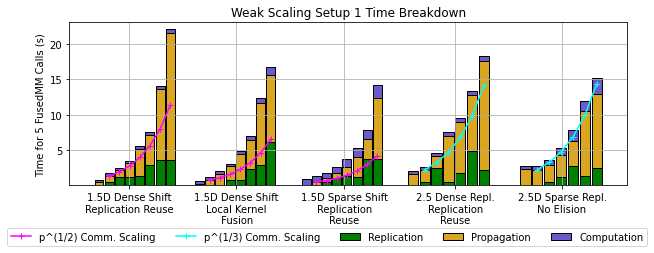

In [5]:
def getBreakdowns(exps, extra=False):
    sCategories = {'Replication Time' : 'Replication', 'Cyclic Shift Time' : 'Propagation', 'Computation Time' : 'Computation', \
                   'Dense Cyclic Shift Time' : 'Propagation', 'Sparse Cyclic Shift Time' : 'Propagation', \
                   'Dense Fiber Communication Time' : 'Replication', 'Sparse Fiber Communication Time' : 'Replication', 'Setup Shift Time' : 'Outside'}
    stups = []
    for exp in exps:
        m = {'Replication' : 0, 'Propagation' : 0, 'Computation' : 0, 'Outside' : 0}
        for key, value in exp['perf_stats'].items():
            m[sCategories[key]] += value
            
        if extra:
            m['Outside'] += exp['application_communication_time']
            
        stups.append((exp['alg_info']['p'], m))
        
    labels = [str(x[0]) for x in stups]
    replications = np.array([x[1]['Replication'] for x in stups])
    propagations = np.array([x[1]['Propagation'] for x in stups])
    computations = np.array([x[1]['Computation'] for x in stups])
    outside = np.array([x[1]['Outside'] for x in stups])
    
    if extra:
        return labels, replications, propagations, computations, outside
    else:
        return labels, replications, propagations, computations

def createBreakdownplot(data, alg_name, fused, ax, offset1, wparam, alg, verbose=False, labelMarker=False, labelColor=False):
    exps = get_best_cval_exps(data, alg_name, fused)[1:]
    labels, replications, propagations, computations=getBreakdowns(exps)
    width = wparam / len(labels)
    
    x = np.linspace(offset1, offset1 + wparam, num=len(labels), endpoint=True)
    
    ax.grid(True)
    if labelColor:
        ax.bar(x, replications, width, label='Replication', edgecolor = "black", color='green')
        ax.bar(x, propagations, width, label='Propagation', bottom=replications, edgecolor = "black", color='goldenrod')
        ax.bar(x, computations, width, label='Computation', bottom=(replications+propagations), edgecolor = "black", color='slateblue')
    else:
        ax.bar(x, replications, width, edgecolor = "black", color='green')
        ax.bar(x, propagations, width, bottom=replications, edgecolor = "black", color='goldenrod')
        ax.bar(x, computations, width, bottom=(replications+propagations), edgecolor = "black", color='slateblue')
        
    basepoint = (replications[1] + propagations[1])
    vals = []
    
    if alg=="15d":
        coeff = np.sqrt(2)
        color='fuchsia'
        label='p^(1/2) Comm. Scaling'
    else:
        coeff = np.cbrt(3)
        color='cyan'
        label='p^(1/3) Comm. Scaling'
    
    for i in range(len(x) - 1):
        vals.append(basepoint)
        basepoint *= coeff
        
    if labelMarker:
        ax.plot(x[1:], vals, marker='+', color=color, label=label)
    else:
        ax.plot(x[1:], vals, marker='+', color=color)
    
    #basepoint
    #if alg=="1.5d":
        
    
    if verbose:
        print(replications)
        print(propagations)
        print(computations)
    
fig, ax = plt.subplots()
fig.set_size_inches(15 * (2/3), 4.5 * (2/3))
exps1 = getExps('weak_scaling_experiments/15d_scaling.out')
exps2 = getExps('weak_scaling_experiments/25d_scaling.out')

createBreakdownplot(exps1, "15d_fusion1", True,  ax, 0.40, 0.234, "15d", labelColor=True)
createBreakdownplot(exps1, "15d_fusion2", True,  ax, 0.73, 0.234, "15d")
createBreakdownplot(exps1, "15d_sparse", True,  ax, 1.08, 0.234, "15d", labelMarker=True)

createBreakdownplot(exps2, "25d_dense_replicate", True,  ax, 1.43, 0.234, "25d")
createBreakdownplot(exps2, "25d_sparse_replicate", False,  ax, 1.8, 0.234, "25d", labelMarker=True)

# ax.set_yscale('log')
ax.set_ylim([0.1, 23])
ax.set_ylabel("Time for 5 FusedMM Calls (s)")

x = np.array([0.5, 0.85, 1.205, 1.57, 1.92])
labels = ["1.5D Dense Shift\nReplication Reuse", "1.5D Dense Shift\nLocal Kernel\n Fusion", "1.5D Sparse Shift\nReplication\nReuse", "2.5 Dense Repl.\nReplication\nReuse", "2.5D Sparse Repl.\nNo Elision"]
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Weak Scaling Setup 1 Time Breakdown")
ax.legend(bbox_to_anchor=(1.045, -0.23), ncol=5)

fig.savefig("ipdps_images/weakscaling_v1_break.pdf", bbox_inches='tight')
#createBreakdownplot(scaling_15d_results, "15d_fusion2", True, '1.5D Fused Strategy 2')
#createBreakdownplot(scaling_15d_results, "15d_sparse", True, '1.5D Sparse Shift Fused')

[8, 16, 8, 16, 8]
4



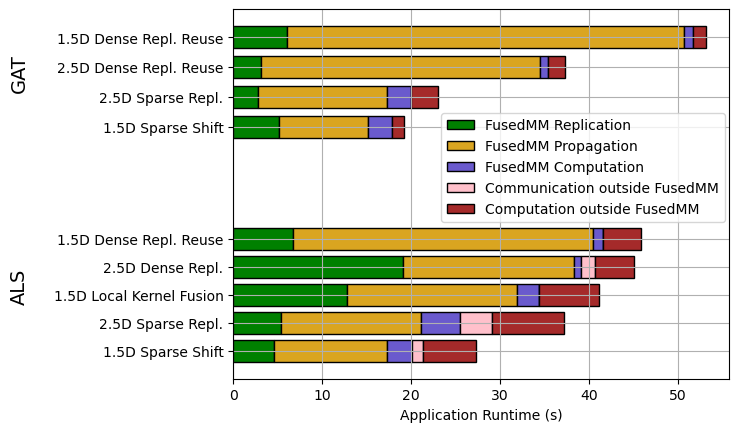

In [622]:
exps_als = getExps_progress('application_experiments/15d_als_breakdown_strong.out') + getExps_progress('application_experiments/25d_als_breakdown_strong.out')
alg_names1 = [('15d_sparse', True), ('25d_sparse_replicate', False), ('15d_fusion2', True), ('25d_dense_replicate', True), ('15d_fusion1', True)
             ]

lastexps = [get_best_cval_exps(exps_als, alg_names1[i][0], alg_names1[i][1])[-1] for i in range(len(alg_names1))]

print([exp['alg_info']['c'] for exp in lastexps])

labels, replications, propagations, computations, outside =getBreakdowns(lastexps, extra=True)
elapsed = np.array([x['elapsed'] for x in lastexps])
delta = elapsed - replications - propagations - computations - outside

x1 = np.linspace(0, 0.5, num=5)
width = 0.1
    
#x = np.linspace(offset1, offset1 + wparam, num=len(labels), endpoint=True)

fig, ax = plt.subplots()

ax.grid(True)
ax.barh(x1, replications, width, label='FusedMM Replication', edgecolor = "black", color='green')
ax.barh(x1, propagations, width, label='FusedMM Propagation', left=replications, edgecolor = "black", color='goldenrod')
ax.barh(x1, computations, width, label='FusedMM Computation', left=(replications+propagations), edgecolor = "black", color='slateblue')
ax.barh(x1, outside, width, label='Communication outside FusedMM', left=(replications+propagations + computations), edgecolor = "black", color='pink')
ax.barh(x1, delta, width, label='Computation outside FusedMM', left=(replications+propagations+computations + outside), edgecolor = "black", color='brown')

#===========================================

exps_als = getExps('application_experiments/15d_gat_strong.out') + getExps('application_experiments/25d_gat_strong.out')
alg_names2 = [('15d_sparse', True),('25d_sparse_replicate', False), ('25d_dense_replicate', True), ('15d_fusion1', True)
             ]

lastexps = [get_best_cval_exps(exps_als, alg_names2[i][0], alg_names2[i][1])[-1] for i in range(len(alg_names2))]
labels, replications, propagations, computations=getBreakdowns(lastexps)
print(len(lastexps))
elapsed = np.array([x['elapsed'] for x in lastexps])
delta = elapsed - replications - propagations - computations

x2 = np.linspace(1.0, 1.4, num=4, endpoint=True)
width = 0.1
    
#x = np.linspace(offset1, offset1 + wparam, num=len(labels), endpoint=True)

ax.grid(True)
ax.barh(x2, replications, width, edgecolor = "black", color='green')
ax.barh(x2, propagations, width, left=replications, edgecolor = "black", color='goldenrod')
ax.barh(x2, computations, width, left=(replications+propagations), edgecolor = "black", color='slateblue')
ax.barh(x2, delta, width, left=(replications+propagations+computations), edgecolor = "black", color='brown')
ax.set_xlabel("Application Runtime (s)")
print()
ax.set_yticks(np.concatenate((x1, x2)))
ax.set_yticklabels(['1.5D Sparse Shift', '2.5D Sparse Repl.', '1.5D Local Kernel Fusion', '2.5D Dense Repl.', '1.5D Dense Repl. Reuse', 
                    '1.5D Sparse Shift', '2.5D Sparse Repl.', '2.5D Dense Repl. Reuse', '1.5D Dense Repl. Reuse'])

ax.text(-0.45, 0.88, "GAT", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', rotation=90)

ax.text(-0.45, 0.30, "ALS", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', rotation=90)

ax.legend(bbox_to_anchor=(0.405, 0.738), framealpha=1.0)

fig.show()
fig.savefig("ipdps_images/app_benchmark.pdf", bbox_inches='tight')

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


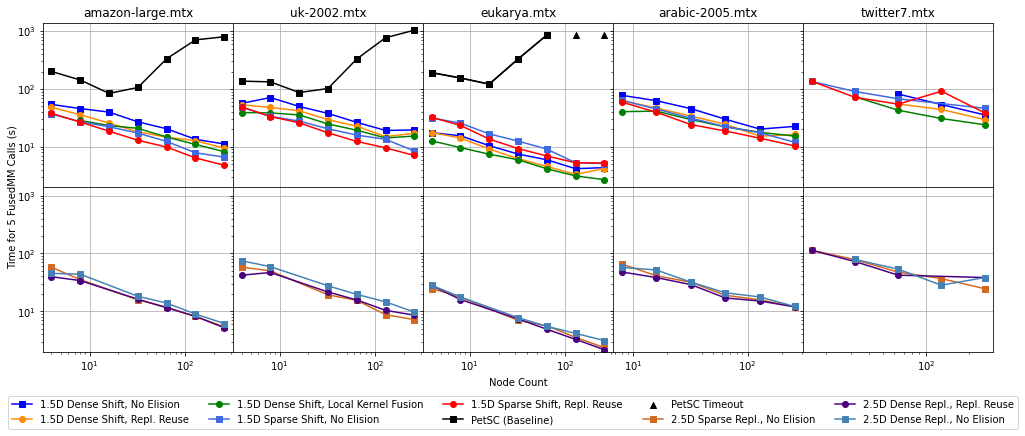

In [7]:
def makeStrongScalingPlot(alg, filename, ax, logscale=True, base_alg=None, baseline_file=None, prog=False, fil=0):
    if not prog:
        exps = getExps(filename)
    else:
        exps = getExps_progress(filename)
    
    if alg=="15d":
        generateScalingPlot(exps, "15d_fusion1", False, "1.5D Dense Shift, No Elision", ('blue', 's'), ax, fil=fil)
        generateScalingPlot(exps, "15d_fusion1", True, "1.5D Dense Shift, Repl. Reuse", ('darkorange', 'o'), ax,fil=fil)
        generateScalingPlot(exps, "15d_fusion2", True, "1.5D Dense Shift, Local Kernel Fusion", ('green', 'o'), ax, fil=fil)
        generateScalingPlot(exps, "15d_sparse", False, "1.5D Sparse Shift, No Elision",('royalblue', 's'), ax, fil=fil)
        generateScalingPlot(exps, "15d_sparse", True, "1.5D Sparse Shift, Repl. Reuse",('red', 'o'), ax, fil=fil)
    elif alg=="25d":
        generateScalingPlot(exps, "25d_sparse_replicate", False, "2.5D Sparse Repl., No Elision", ('chocolate', 's'), ax, fil=fil)
        generateScalingPlot(exps, "25d_dense_replicate", True, "2.5D Dense Repl., Repl. Reuse", ('indigo', 'o'), ax, fil=fil)
        generateScalingPlot(exps, "25d_dense_replicate", False, "2.5D Dense Repl., No Elision", ('steelblue', 's'), ax, fil=fil)
        
    if logscale:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    #if base_alg is not None:
    #    exps = get_best_cval_exps(exps, base_alg[0], base_alg[1])
    #    basepoint = (exps[0]['alg_info']['p'], getTotalTime(exps[0]))
    #    h_axis = []
    #    h_counter = basepoint[0]
    #    counter = basepoint[1]
    #    values = []
    #    while h_counter <= 256:
    #        values += [counter]
    #        h_axis += [h_counter]
    #        counter /= 2
    #        h_counter *= 2
        
        #ax.plot(h_axis, values, color='black', linestyle='dashed', label="Ideal Scaling")
    
    if baseline_file is not None:
        exps = getExps(baseline_file)
        xvals = [exp['alg_info']['p'] / 68 for exp in exps]
        yvals = [exp['elapsed'] for exp in exps]
        
        ax.plot(xvals, yvals, c='black', label="PetSC (Baseline)", marker='s')
        
        # There was a timeout for this baseline, so we
        if baseline_file=='petsc_baseline/petsc_eukarya_strong64.out':
            highpt = yvals[-1]
            ax.plot(xvals, yvals, c='black')
            ax.scatter(xvals, yvals, c='black', marker='s')
            ax.scatter([128, 256], [highpt, highpt], c='black', marker='^', label="PetSC Timeout")
        
    
    ax.grid(True)

#fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, tight_layout=True)
#fig.set_size_inches(21.5 * (2/3), 10.5 * (2/3))

fig = plt.figure()
fig.set_size_inches(15 * (1.1), 5.5 * (1.1))
spec = fig.add_gridspec(2, 5, wspace=0, hspace=0.0, left=0.0, right=0.8)
axs = [[fig.add_subplot(spec[i, j]) for j in range(5)] for i in range(2)]

makeStrongScalingPlot('15d', 'strong_scaling_experiments/15d_amazon_strong.out', axs[0][0], base_alg=('15d_sparse', True), baseline_file='petsc_baseline/petsc_amazon_strong64.out')
#axs[0][0].set_ylabel("Time for 5 FusedMM Calls (s)")
#axs[0, 0].set_ylim([2.0, 80])
axs[0][0].set_title("amazon-large.mtx")
makeStrongScalingPlot('15d', 'strong_scaling_experiments/15d_uk_strong.out', axs[0][1], base_alg=('15d_sparse', True), baseline_file='petsc_baseline/petsc_uk_strong64.out')
axs[0][1].set_title("uk-2002.mtx")
makeStrongScalingPlot('15d', 'strong_scaling_experiments/15d_eukarya_strong.out', axs[0][2], base_alg=('15d_fusion2', True), baseline_file='petsc_baseline/petsc_eukarya_strong64.out')
axs[0][2].set_title("eukarya.mtx")

makeStrongScalingPlot('25d', 'strong_scaling_experiments/25d_amazon_strong.out', axs[1][0], base_alg=('25d_dense_replicate', True))
#axs[1][0].set_ylabel("Time for 5 FusedMM Calls (s)")
makeStrongScalingPlot('25d', 'strong_scaling_experiments/25d_uk_strong.out', axs[1][1], base_alg=('25d_dense_replicate', True))
makeStrongScalingPlot('25d', 'strong_scaling_experiments/25d_eukarya_strong.out', axs[1][2], base_alg=('25d_sparse_replicate', False)) 

makeStrongScalingPlot('15d', 'strong_scaling_experiments/15d_twitter7_strong.out', axs[0][4], base_alg=('25d_sparse_replicate', False), prog=True)
makeStrongScalingPlot('25d', 'strong_scaling_experiments/25d_twitter7_strong.out', axs[1][4], base_alg=('25d_sparse_replicate', False), prog=True)
axs[0][4].set_title("twitter7.mtx")

makeStrongScalingPlot('15d', 'strong_scaling_experiments/15d_arabic_strong.out', axs[0][3], base_alg=('25d_sparse_replicate', False), prog=True, fil=4)
makeStrongScalingPlot('25d', 'strong_scaling_experiments/25d_arabic_strong.out', axs[1][3], base_alg=('25d_sparse_replicate', False), prog=True, fil=4)
axs[0][3].set_title("arabic-2005.mtx")

fig.text(0.40, 0.046, 'Node Count', ha='center')
fig.text(-0.03, 0.32, "Time for 5 FusedMM Calls (s)", rotation='vertical')
h25d, l25d = axs[1][1].get_legend_handles_labels()
h15d, l15d = axs[0][2].get_legend_handles_labels()

axs[0][0].sharey(axs[0][0])
axs[0][1].sharey(axs[0][0])
axs[1][0].sharey(axs[0][0])
axs[0][2].sharey(axs[0][0])
axs[0][3].sharey(axs[0][0])
axs[0][4].sharey(axs[0][0])
#axs[0][4].sharex(axs[0][1])

axs[1][1].sharey(axs[0][0])
axs[1][2].sharey(axs[0][0])
axs[1][3].sharey(axs[0][0])
axs[1][4].sharey(axs[0][0])
axs[1][4].sharex(axs[0][4])

axs[0][1].sharex(axs[1][1])

axs[0][1].label_outer()
axs[1][1].label_outer()
axs[0][2].label_outer()
axs[0][3].label_outer()
axs[1][2].label_outer()
axs[1][3].label_outer()

axs[0][4].label_outer()
axs[1][4].label_outer()

fig.legend(h15d+h25d, l15d+l25d, bbox_to_anchor=(0.825, 0.035), ncol=5)
#fig.legend(h25d, l25d, bbox_to_anchor=(1.0, 0.4))
fig.show()
fig.savefig("ipdps_images/strong_scaling_baseline.pdf", bbox_inches='tight')

In [1]:
#exps = getExps_progress("strong_scaling_experiments/15d_twitter7_strong.out")
#for exp in exps:
    #if exp['alg_info']['p']==128:
    #print("{}, {}, {}, {}".format(exp['alg_info']['p'], exp['alg_info']['c'], exp['alg_name'], exp['elapsed']))

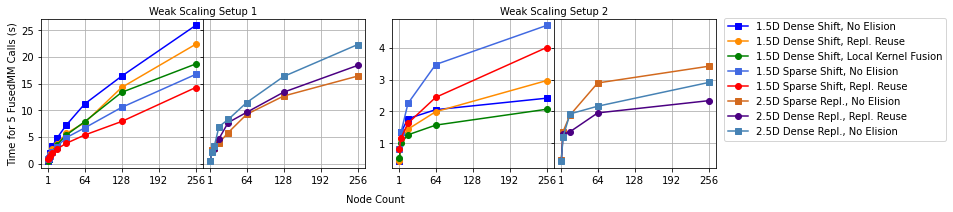

In [586]:
fig = plt.figure(figsize=(8, 8))

spec = fig.add_gridspec(1, 2, wspace=0, left=0.0, right=0.6)
fig.set_size_inches(15 * (1/2), 5.5 * (1/2))

tick_locations = [1, 64, 128, 192, 256]

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
makeStrongScalingPlot('15d', 'weak_scaling_experiments/15d_scaling.out', ax0, logscale=False)
ax0.set_ylabel("Time for 5 FusedMM Calls (s)")
makeStrongScalingPlot('25d', 'weak_scaling_experiments/25d_scaling.out', ax1, logscale=False)

ax0.sharey(ax1)
ax1.label_outer()
ax0.set_xticks(tick_locations)
ax1.set_xticks(tick_locations)

#fig.show()
#fig.savefig("ipdps_images/weakscaling_setup1.pdf", bbox_inches='tight')

h15d, l15d = ax0.get_legend_handles_labels()

#fig, axs = plt.subplots(1, 4, sharey='row', tight_layout=True)
#fig.set_size_inches(15 * (1/2), 5.5 * (1/2))

spec = fig.add_gridspec(1, 2, wspace=0, left=0.65, right=1.25)
ax2 = fig.add_subplot(spec[0, 0])
ax3 = fig.add_subplot(spec[0, 1])
#fig.suptitle("Weak Scaling Setup 2",y=1.05, fontsize=14)
makeStrongScalingPlot('15d', 'weak_scaling_experiments/15d_scaling_v2.out', ax2, logscale=False)
#axs[0].set_ylabel("Time for 5 FusedMM Calls (s)")
#axs[0].set_xlabel("Number of Nodes")
makeStrongScalingPlot('25d', 'weak_scaling_experiments/25d_scaling_v2.out', ax3, logscale=False)
ax2.sharey(ax3)
ax3.label_outer()

ax2.set_xticks(tick_locations)
ax3.set_xticks(tick_locations)


fig.text(0.62, -0.05, 'Node Count', ha='center')
fig.text(0.3, 0.9, 'Weak Scaling Setup 1', ha='center')
fig.text(0.95, 0.9, 'Weak Scaling Setup 2', ha='center')
#axs[1].set_xlabel("Number of Nodes")
#fig.savefig("ipdps_images/weakscaling_combined.pdf", bbox_inches='tight')

h25d, l25d = ax1.get_legend_handles_labels()

#fig.set_size_inches(15 * (1/2), 5.5 * (1/2))
leg = fig.legend(h15d + h25d, l15d + l25d, loc='upper center', bbox_to_anchor=(1.47, 0.91))

#leg = fig.legend(h25d, l25d, loc='upper center', bbox_to_anchor=(0.87, 0.5))

fig.show()
fig.savefig("ipdps_images/weakscaling_unified.pdf", bbox_inches='tight')


<Figure size 576x576 with 0 Axes>

In [10]:
weak_exps = getExps('weak_scaling_experiments/15d_scaling.out')

In [31]:
alg_names2 = [('15d_sparse', True),('25d_sparse_replicate', False), ('25d_dense_replicate', True), ('15d_fusion1', True),
              ('15d_sparse', False), ('15d_fusion1', False), ('25d_dense_replicate', False), ('15d_fusion2', True)
             ]

firstexps = get_best_cval_exps(weak_exps, '15d_sparse', True)

for exp in firstexps:
    print("{}\t{}\t{}\t{}".format(exp['alg_info']['p'], exp['alg_name'], exp['fused'], getTotalTime(exp)))
    
    
    
throughput_dummy = (2 ** 16) * 1 * 32 * 256 * 5 * 2 / 0.83
print("Dummy Throughput: {:e}".format(throughput_dummy))

1	15d_sparse	True	0.837529797
2	15d_sparse	True	1.036933992
4	15d_sparse	True	1.463007906
8	15d_sparse	True	1.969684017
16	15d_sparse	True	2.761679464
32	15d_sparse	True	3.814447761
64	15d_sparse	True	5.369184414
128	15d_sparse	True	7.899415726000001
256	15d_sparse	True	14.241181273
Dummy Throughput: 6.468324e+09


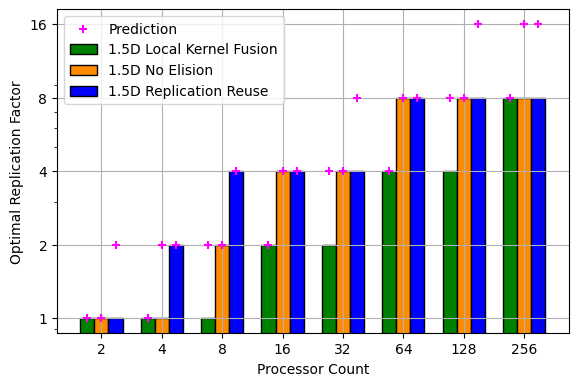

In [5]:
plt.style.use('default')

def fusion2model(exp, c):
    p = exp['alg_info']['p']
    r = exp['alg_info']['r']
    n = exp['alg_info']['n']
    
    return n * r / c + (2 * (c - 1) * n * r / p)

def unfusedmodel(exp, c):
    p = exp['alg_info']['p']
    r = exp['alg_info']['r']
    n = exp['alg_info']['n']
    
    return 2 * n * r / c + (2 * (c - 1) * n * r / p)

def fusionmodel1(exp, c):
    p = exp['alg_info']['p']
    r = exp['alg_info']['r']
    n = exp['alg_info']['n']
    
    return 2 * n * r / c + (1 * (c - 1) * n * r / p)

def getOptimal(exp, model):
    testVals = np.array([1, 2, 4, 8, 16, 32])
    return testVals[np.argmin(model(exp, testVals))]


exps = getExps('weak_scaling_experiments/15d_scaling.out')
predfusion2 = [getOptimal(x, fusion2model)  for x in get_best_cval_exps(exps, '15d_fusion2', True)][1:]
predunfused = [getOptimal(x, unfusedmodel) for x in get_best_cval_exps(exps, '15d_fusion1', False)][1:]
predfusion1 = [getOptimal(x, fusionmodel1) for x in get_best_cval_exps(exps, '15d_fusion1', True)][1:]

fusion2_cvals = [x['alg_info']['c'] for x in get_best_cval_exps(exps, '15d_fusion2', True)][1:]
unfused_cvals = [x['alg_info']['c'] for x in get_best_cval_exps(exps, '15d_fusion1', False)][1:]
fusion1_cvals = [x['alg_info']['c'] for x in get_best_cval_exps(exps, '15d_fusion1', True)][1:]

pvals = np.array([x['alg_info']['p'] for x in get_best_cval_exps(exps, '15d_fusion1', True)][1:])
labels = [str(x) for x in pvals]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(16.5 * (0.4), 10.5 * (0.4))
ax.bar(x - width/3*2, fusion2_cvals, width * 2 / 3, label='1.5D Local Kernel Fusion',color='green', edgecolor = "black")
ax.bar(x, unfused_cvals, width * 2 / 3, label='1.5D No Elision',color='darkorange', edgecolor = "black")
ax.bar(x + width/3*2, fusion1_cvals, width * 2 / 3, label='1.5D Replication Reuse',color='blue', edgecolor = "black")

plt.scatter(x-width/3*2, predfusion2, marker="+", color="fuchsia", zorder=3)
plt.scatter(x, predunfused, marker="+", color="fuchsia", zorder=3)
plt.scatter(x+width/3*2, predfusion1, marker="+", color="fuchsia", zorder=3, label="Prediction")
ax.set_yscale('log')
ax.set_yticks([1, 2, 4, 8, 16])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Optimal Replication Factor")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Processor Count")
ax.grid()
plt.legend()
plt.show()

fig.savefig("ipdps_images/optimal_replication.pdf", bbox_inches='tight')

In [1177]:
# Get the best fused speedup on strong scaling

exps_als = getExps('strong_scaling_experiments/15d_eukarya_strong.out') + getExps('strong_scaling_experiments/25d_eukarya_strong.out')
alg_names2 = [('15d_sparse', True),('25d_sparse_replicate', False), ('25d_dense_replicate', True), ('15d_fusion1', True),
              ('15d_sparse', False), ('15d_fusion1', False), ('25d_dense_replicate', False), ('15d_fusion2', True)
             ]

lastexps = [get_best_cval_exps(exps_als, alg_names2[i][0], alg_names2[i][1])[-1] for i in range(len(alg_names2))]

dict = {}
for exp in lastexps:
    print("{}\t\t{}\t{}".format(exp['alg_name'], exp['fused'], getTotalTime(exp)))
    dict[(exp['alg_name'], exp['fused'])] = getTotalTime(exp)
    
# Print the speedup of Eukarya on fusion version 2



15d_sparse		True	5.242632729
25d_sparse_replicate		False	2.345798563
25d_dense_replicate		True	2.16074976
15d_fusion1		True	4.219745769
15d_sparse		False	5.129978375
15d_fusion1		False	4.37230205
25d_dense_replicate		False	3.115372773
15d_fusion2		True	2.704648542


In [1181]:
# Get the best speedup on Eukarya

eukarya_best_speedup = dict["15d_fusion1", False] / dict["15d_fusion2", True]

print("Eukarya Best Speedup, Fused: {}".format(eukarya_best_speedup))

Eukarya Best Speedup, Fused: 1.6165878790176649


In [4]:
import scipy.stats

# Get the best fused speedup on strong scaling

exps_als = getExps('strong_scaling_experiments/15d_eukarya_strong.out') + getExps('strong_scaling_experiments/25d_eukarya_strong.out')
alg_names2 = [('15d_sparse', True),('25d_sparse_replicate', False), ('25d_dense_replicate', True), ('15d_fusion1', True),
              ('15d_sparse', False), ('15d_fusion1', False), ('25d_dense_replicate', False), ('15d_fusion2', True)
             ]

lastexps = [get_best_cval_exps(exps_als, alg_names2[i][0], alg_names2[i][1])[-1] for i in range(len(alg_names2))]

dict = {}
for exp in lastexps:
    print("{}\t\t{}\t{}".format(exp['alg_name'], exp['fused'], getTotalTime(exp)))
    dict[(exp['alg_name'], exp['fused'])] = getTotalTime(exp)

    
print("=======================")
# Find the strong scaling efficiency of each.

for name in alg_names2:
    exps = get_best_cval_exps(exps_als, name[0], name[1])
    pvals = np.array([exp['alg_info']['p'] for exp in exps])
    times = np.array([getTotalTime(exp) for exp in exps])
    
    
    res = scipy.stats.linregress(np.log2(pvals), y=np.log2(times))
    #print("{}\t{}\t{}".format(name[0], name[1], dict[name]))


15d_sparse		True	5.242632729
25d_sparse_replicate		False	2.345798563
25d_dense_replicate		True	2.16074976
15d_fusion1		True	4.219745769
15d_sparse		False	5.129978375
15d_fusion1		False	4.37230205
25d_dense_replicate		False	3.115372773
15d_fusion2		True	2.704648542


In [1203]:
15.34/7.08

2.1666666666666665

In [1204]:
7.15/7.08

1.0098870056497176

In [1206]:
5.24/2.7

1.9407407407407407

In [3]:
exps_als = getExps('weak_scaling_experiments/15d_scaling.out') + getExps('weak_scaling_experiments/25d_scaling.out')
alg_names2 = [('15d_sparse', True),('25d_sparse_replicate', False), ('25d_dense_replicate', True), ('15d_fusion1', True),
              ('15d_sparse', False), ('15d_fusion1', False), ('25d_dense_replicate', False), ('15d_fusion2', True)
             ]

lastexps = [get_best_cval_exps(exps_als, alg_names2[i][0], alg_names2[i][1])[-1] for i in range(len(alg_names2))]

dict = {}
for exp in lastexps:
    print("{}\t\t{}\t{}".format(exp['alg_name'], exp['fused'], getTotalTime(exp)))
    dict[(exp['alg_name'], exp['fused'])] = getTotalTime(exp)
    

15d_sparse		True	14.241181273
25d_sparse_replicate		False	16.382786839
25d_dense_replicate		True	18.379623188
15d_fusion1		True	22.325811908
15d_sparse		False	16.698089936
15d_fusion1		False	25.856556266
25d_dense_replicate		False	22.278187663
15d_fusion2		True	18.64558319


In [1213]:
25.85/22.32

1.1581541218637994

In [1214]:
exps_als = getExps('weak_scaling_experiments/15d_scaling_v2.out') + getExps('weak_scaling_experiments/25d_scaling_v2.out')
alg_names2 = [('15d_sparse', True),('25d_sparse_replicate', False), ('25d_dense_replicate', True), ('15d_fusion1', True),
              ('15d_sparse', False), ('15d_fusion1', False), ('25d_dense_replicate', False), ('15d_fusion2', True)
             ]

lastexps = [get_best_cval_exps(exps_als, alg_names2[i][0], alg_names2[i][1])[-1] for i in range(len(alg_names2))]

dict = {}
for exp in lastexps:
    print("{}\t\t{}\t{}".format(exp['alg_name'], exp['fused'], getTotalTime(exp)))
    dict[(exp['alg_name'], exp['fused'])] = getTotalTime(exp)

15d_sparse		True	3.999968379
25d_sparse_replicate		False	3.414387077
25d_dense_replicate		True	2.337562412
15d_fusion1		True	2.965727946
15d_sparse		False	4.690710374
15d_fusion1		False	2.4153661029999998
25d_dense_replicate		False	2.906639443
15d_fusion2		True	2.069167326


In [3]:
# Expected configurations in the heatmap
configs = []
nnz_list = [21, 43, 64, 85, 107, 128, 149]
r_list = [64, 128, 192, 256, 320, 384, 448]

for i in nnz_list:
    for j in r_list:
        for c in [2, 8]:
            configs.append((i, j, c, "25d_sparse_replicate"))
            configs.append((i, j, c, "25d_dense_replicate"))
            
        for c in [1, 2, 4, 8]:
            configs.append((i, j, c, "15d_fusion1"))
            configs.append((i, j, c, "15d_fusion2"))
            configs.append((i, j, c, "15d_sparse"))
            
# Find a list of missing configurations from our experiment list
exps = getExps_progress("heatmap_experiments/heatmap1.out")

config_map = {}

for exp in exps:
    nnz_per_row = min(nnz_list, key=lambda x:abs(x - exp['alg_info']['nnz'] / exp['alg_info']['m']))
    
    key = (nnz_per_row, exp['alg_info']['r'], exp['alg_info']['c'], exp['alg_name'])
    if key not in config_map.keys():
        config_map[key] = [exp['elapsed']]
    else:
        config_map[key].append(exp['elapsed'])
        
exps = getExps_progress("heatmap_experiments/heatmap2.out")

for exp in exps:
    nnz_per_row = min(nnz_list, key=lambda x:abs(x - exp['alg_info']['nnz'] / exp['alg_info']['m']))
    
    key = (nnz_per_row, exp['alg_info']['r'], exp['alg_info']['c'], exp['alg_name'])
    if key not in config_map.keys():
        config_map[key] = [exp['elapsed']]
    else:
        config_map[key].append(exp['elapsed'])

def getWinnersLosers(config_map):
    # Map down the configurations to find the best c value for each algorithm.
    mapped_down = {}
    for key in config_map.keys():
        map_key = (key[0], key[1], key[3])
        if map_key not in mapped_down.keys():
            mapped_down[map_key] = [(key[2], config_map[key][0])]
        else:
            mapped_down[map_key].append((key[2], config_map[key][0]))
        
    best_cvalues = {}
    for key in mapped_down.keys():
        vals = [x[1] for x in mapped_down[key]]
        best_cvalues[key] = mapped_down[key][np.argmin(vals)]
    
    mapped_down_second = {}
    for key in best_cvalues.keys():
        map_key = (key[0], key[1])
        if map_key not in mapped_down_second.keys():
            mapped_down_second[map_key] = [(key[2], best_cvalues[key][1])]
        else:
            mapped_down_second[map_key].append((key[2], best_cvalues[key][1]))
        
    winners = {}
    losers = {}

    for key in mapped_down_second.keys():
        vals = [x[1] for x in mapped_down_second[key]]
        winners[key] = mapped_down_second[key][np.argmin(vals)][0]
        losers[key] = mapped_down_second[key][np.argmax(vals)][0]
        
    return winners, losers
    
# "15d_fusion1": ([147, 217, 9], # Same color; we don't care about the replication strategy here. 

color_scheme = {"15d_fusion1": ([147, 217, 9], "1.5D Dense Shift w/\n Local Kernel Fusion"),
                "15d_fusion2": ([147, 217, 9], "1.5D Dense Shift w/\n Local Kernel Fusion"),
                "15d_sparse": ([90, 133, 5], "1.5D Sparse Shift w/\n Replication Reuse"),
                "25d_dense_replicate": ([128, 10, 207], "2.5D Dense Replicate, Kernel Overlap"),
                "25d_sparse_replicate": ([81, 7, 130], "2.5D Sparse Replicate, Back-to-Back")}

def plot_heatmap(ax, algs, label=True):

    img = np.zeros((len(nnz_list), len(r_list), 3), dtype=np.int32)
    for i in range(len(nnz_list)):
        for j in range(len(r_list)):
            img[len(nnz_list) - i - 1, j] = color_scheme[algs[(nnz_list[i], r_list[j])]][0]
    ax.imshow(img)

    ax.set_xticks(np.arange(0, 7, 1))
    ax.set_yticks(np.arange(0, 7, 1))

    ax.set_xticklabels(r_list)
    ax.set_yticklabels(list(reversed(nnz_list)))

    ax.set_xticks(np.arange(-.5, 7, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 7, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.plot([-0.5, 6.5], [6.5, -0.5], 'r--')
    
    if label:
        ax.set_ylabel("NNZ per row of S")
    
def heatmap_legend():
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_elements = [Patch(facecolor=tuple(i / 255 for i in color_scheme[key][0]), edgecolor='w',
                         label=color_scheme[key][1]) for key in list(color_scheme.keys())[1:3]
                  ]
    legend_elements.append(Line2D([0], [0], color='r', linestyle='--', label='3 nnz(S) / r = 1'))

    return legend_elements

f = open("distributed_sddmm/heatmap_experiments/theoretical_heatmap.json")
theoreticalResults = json.load(f)

from ast import literal_eval as make_tuple

theoretical_map = {}

for key in theoreticalResults.keys():
    lst = key[1:-1].split(',')
    theoretical_map[(int(lst[0]), int(lst[1]), int(lst[2]), lst[3])] = [theoreticalResults[key]]
    
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plot_heatmap(axs[0], getWinnersLosers(theoretical_map)[0])
plot_heatmap(axs[1], getWinnersLosers(config_map)[0], label=False)
axs[0].set_title("Predicted")
axs[1].set_title("Observed")
plt.subplots_adjust(wspace=0.05, hspace=0.01)
fig.text(0.5, 0.1, 'Value of r', ha='center')

plt.legend(handles=heatmap_legend(), bbox_to_anchor=(1.91, 1.03), title="Fastest Algorithm", title_fontsize="large")
fig.savefig("ipdps_images/heatmaps.pdf", bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'distributed_sddmm/heatmap_experiments/heatmap1.out'